Решаем задачу фонетического транскрибирования.

За основу взят код: https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

# Download and prepare dataset

https://github.com/cmusphinx/cmudict репозиторий с транскрипцией для англ.яз.
https://www.dropbox.com/s/4nd6u4anb2o1vnt/ru.dic?dl=0 данные для русского языка

Что мы будем делать

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [ ]:
!wget -O ru.dic https://www.dropbox.com/s/4nd6u4anb2o1vnt/ru.dic?dl=0

--2021-01-29 16:03:14--  https://www.dropbox.com/s/4nd6u4anb2o1vnt/ru.dic?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4nd6u4anb2o1vnt/ru.dic [following]
--2021-01-29 16:03:14--  https://www.dropbox.com/s/raw/4nd6u4anb2o1vnt/ru.dic
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5d4d223bf945e3cf43192eb72b.dl.dropboxusercontent.com/cd/0/inline/BH4QQToeJUTJ4HXwo_H_SOBlUuU8UoZEGDNqfSHOewLL0y7VAYtwutqKafV3wTOoji8_4S1ZubpKtNOWdSGuKeVVaGaGc_lzzmWuAiWY92hvHFtZ3GfBnzE1tAWeAPwsWLw/file# [following]
--2021-01-29 16:03:15--  https://uc5d4d223bf945e3cf43192eb72b.dl.dropboxusercontent.com/cd/0/inline/BH4QQToeJUTJ4HXwo_H_SOBlUuU8UoZEGDNqfSHOewLL0y7VAYtwutqKafV3wTOoji8_4S1ZubpKtNOWdSGuKeVVaGaGc_lzzmWuAiWY92hvHFtZ3GfBnzE1tAWe

In [ ]:
path = "/content/ru.dic"

with open(path, "r") as f:
    ru_phon = f.read()

Нам нужно из одного файла сделать 2 набора данных. Я не придумала ничего лучше, кроме как сплитнуть сначала по '\n' на пары, а потом регуляркой разбить эту пару и добавить левый элемент в один список, а правый - в другой.

Кстати, split() из коробки питона сработал странно: когда пыталась взять какой-то элемент списка, оперативка переполнялась и ничего мне не показывалось.

In [ ]:
ru_phon[:14]

'а a1\nа(2) a0\nа'

In [ ]:
import re
phon_pairs = re.split(r'\n', ru_phon)

In [ ]:
phon_pairs[:10]

['а a1',
 'а(2) a0',
 'а-их-ма-хма a1 i1 h m a1 h m a1',
 'а-их-ма-хма(2) a0 i1 h m a1 h m a1',
 'а-ля a1 lj a1',
 'а-ля(2) a0 lj a1',
 'а-ля-бальзак a1 lj a1 b a0 lj z a1 k',
 'а-ха-ха a1 h a1 h a1',
 'аа a1',
 'аадниель a0 a0 d nj i0 j e1 lj']

In [ ]:
rus_seq_raw = []

for pair in phon_pairs:
  result = re.findall(r'[а-я-]+[(\d)]*', pair)
  out = ''.join(result)
  rus_seq_raw.append(out)

In [ ]:
rus_seq_raw[:5]

['а', 'а(2)', 'а-их-ма-хма', 'а-их-ма-хма(2)', 'а-ля']

In [ ]:
rus_transcr_raw = []

for pair in phon_pairs:
  result = re.findall(r'([a-z]+\d*.*)', pair)
  out = ''.join(result)
  rus_transcr_raw.append(out)

In [ ]:
rus_transcr_raw[:5]

['a1', 'a0', 'a1 i1 h m a1 h m a1', 'a0 i1 h m a1 h m a1', 'a1 lj a1']

In [ ]:
len(rus_seq_raw) == len(rus_transcr_raw)

True

Теперь предобработка. Тоже способ "в лоб", но иногда приходится ручками чистить. Поколдуем с типами данных, несколько раз сплитнем и снова соединим.

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def preprocess_transcribtion(w):
  w = '<start> ' + w + ' <end>'
  return w

def preprocess_sequences(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r'-', '', w)
  w = re.sub(r'\(\d\)', '', w)
  w = list(' '.join(w))
  w = ''.join(w)
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
seq_example = u"а-их-ма-хма(2)"
transc_example = u"a0 i1 h m a1 h m a1"
print(preprocess_sequences(seq_example))
print(preprocess_transcribtion(transc_example).encode('utf-8'))

<start> а и х м а х м а <end>
b'<start> a0 i1 h m a1 h m a1 <end>'


Получаем токены. В нашем случае токен=букве или токен=звуку, зависит от списка, какой у нас из двух.

In [ ]:
def get_tokens(seq):
  seq_split_symbols = re.split(r' ', seq)
  return seq_split_symbols

In [ ]:
seq_example_2 = u"<start> а их ма хма <end>"
transc_example_2 = u"<start> a0 i1 h m a1 h m a1 <end>"
print(get_tokens(seq_example_2))
print(get_tokens(transc_example_2))

['<start>', 'а', 'их', 'ма', 'хма', '<end>']
['<start>', 'a0', 'i1', 'h', 'm', 'a1', 'h', 'm', 'a1', '<end>']


In [ ]:
rus_seq_clean = [preprocess_sequences(w) for w in rus_seq_raw]

In [ ]:
rus_seq_clean[:10]

['<start> а <end>',
 '<start> а <end>',
 '<start> а и х м а х м а <end>',
 '<start> а и х м а х м а <end>',
 '<start> а л я <end>',
 '<start> а л я <end>',
 '<start> а л я б а л ь з а к <end>',
 '<start> а х а х а <end>',
 '<start> а а <end>',
 '<start> а а д н и е л ь <end>']

In [ ]:
rus_seq = [seq.split(' ') for seq in rus_seq_clean]

In [ ]:
rus_seq[:10]

[['<start>', 'а', '<end>'],
 ['<start>', 'а', '<end>'],
 ['<start>', 'а', 'и', 'х', 'м', 'а', 'х', 'м', 'а', '<end>'],
 ['<start>', 'а', 'и', 'х', 'м', 'а', 'х', 'м', 'а', '<end>'],
 ['<start>', 'а', 'л', 'я', '<end>'],
 ['<start>', 'а', 'л', 'я', '<end>'],
 ['<start>', 'а', 'л', 'я', 'б', 'а', 'л', 'ь', 'з', 'а', 'к', '<end>'],
 ['<start>', 'а', 'х', 'а', 'х', 'а', '<end>'],
 ['<start>', 'а', 'а', '<end>'],
 ['<start>', 'а', 'а', 'д', 'н', 'и', 'е', 'л', 'ь', '<end>']]

In [ ]:
rus_transcr_clean = [preprocess_transcribtion(w) for w in rus_transcr_raw]

In [ ]:
rus_transcr_clean[:10]

['<start> a1 <end>',
 '<start> a0 <end>',
 '<start> a1 i1 h m a1 h m a1 <end>',
 '<start> a0 i1 h m a1 h m a1 <end>',
 '<start> a1 lj a1 <end>',
 '<start> a0 lj a1 <end>',
 '<start> a1 lj a1 b a0 lj z a1 k <end>',
 '<start> a1 h a1 h a1 <end>',
 '<start> a1 <end>',
 '<start> a0 a0 d nj i0 j e1 lj <end>']

In [ ]:
rus_transcr = [seq.split(' ') for seq in rus_transcr_clean]

In [ ]:
rus_transcr[:10]

[['<start>', 'a1', '<end>'],
 ['<start>', 'a0', '<end>'],
 ['<start>', 'a1', 'i1', 'h', 'm', 'a1', 'h', 'm', 'a1', '<end>'],
 ['<start>', 'a0', 'i1', 'h', 'm', 'a1', 'h', 'm', 'a1', '<end>'],
 ['<start>', 'a1', 'lj', 'a1', '<end>'],
 ['<start>', 'a0', 'lj', 'a1', '<end>'],
 ['<start>', 'a1', 'lj', 'a1', 'b', 'a0', 'lj', 'z', 'a1', 'k', '<end>'],
 ['<start>', 'a1', 'h', 'a1', 'h', 'a1', '<end>'],
 ['<start>', 'a1', '<end>'],
 ['<start>', 'a0', 'a0', 'd', 'nj', 'i0', 'j', 'e1', 'lj', '<end>']]

Теперь меняем символы на чиселки и делаем паддинг.

In [ ]:
def tokenize(data):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(data)

  tensor = tokenizer.texts_to_sequences(data)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, tokenizer

In [ ]:
def load_dataset(seq1, seq2, num_examples=None):

  target_seq, input_seq = seq1[:num_examples], seq2[:num_examples]

  input_tensor, input_tokenizer = tokenize(input_seq)
  target_tensor, target_tokenizer = tokenize(target_seq)

  return input_tensor, target_tensor, input_tokenizer, target_tokenizer

### Limit the size of the dataset to experiment faster (optional)

100к будут долго тренироваться, поэтому попробуем 10к. Качество пострадает.

In [ ]:
num_examples = 10000
input_tensor, target_tensor, input_seq, target_seq = load_dataset(rus_transcr, rus_seq, num_examples)

# max_length для target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# training-validation sets 80 на 20 
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

8000 8000 2000 2000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input sequence; index to word mapping")
convert(input_seq, input_tensor_train[0])
print ()
print ("Target sequence; index to word mapping")
convert(target_seq, target_tensor_train[0])

Input sequence; index to word mapping
2 ----> <start>
1 ----> а
13 ----> м
18 ----> б
1 ----> а
3 ----> <end>

Target sequence; index to word mapping
2 ----> <start>
5 ----> a1
14 ----> m
27 ----> b
1 ----> a0
3 ----> <end>


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(input_seq.word_index)+1
vocab_tar_size = len(target_seq.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 32]), TensorShape([64, 32]))

#Create a seq2seq model

##Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 22, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 51)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_seq.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 13

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.1837
Epoch 1 Loss 0.1596
Time taken for 1 epoch 1.7960047721862793 sec

Epoch 2 Batch 0 Loss 0.1577
Epoch 2 Loss 0.1321
Time taken for 1 epoch 1.9803307056427002 sec

Epoch 3 Batch 0 Loss 0.0972
Epoch 3 Loss 0.1184
Time taken for 1 epoch 1.7372469902038574 sec

Epoch 4 Batch 0 Loss 0.0987
Epoch 4 Loss 0.1129
Time taken for 1 epoch 1.9902820587158203 sec

Epoch 5 Batch 0 Loss 0.0976
Epoch 5 Loss 0.1174
Time taken for 1 epoch 1.7228965759277344 sec

Epoch 6 Batch 0 Loss 0.1285
Epoch 6 Loss 0.1072
Time taken for 1 epoch 2.0121352672576904 sec

Epoch 7 Batch 0 Loss 0.0842
Epoch 7 Loss 0.0819
Time taken for 1 epoch 1.7191922664642334 sec

Epoch 8 Batch 0 Loss 0.0722
Epoch 8 Loss 0.0733
Time taken for 1 epoch 2.0622782707214355 sec

Epoch 9 Batch 0 Loss 0.0753
Epoch 9 Loss 0.0711
Time taken for 1 epoch 1.7222728729248047 sec

Epoch 10 Batch 0 Loss 0.0714
Epoch 10 Loss 0.0658
Time taken for 1 epoch 2.0266573429107666 sec

Epoch 11 Batch 0 Loss 0.0651
Epoch 11 Loss 0.058

# Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sequences(sentence)

  inputs = [input_seq.word_index[i] for i in get_tokens(sentence)]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_seq.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_seq.index_word[predicted_id] + ' '

    if target_seq.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Потестируем на каких-нибудь словах (реальных и выдуманных; ведь модели это неважно, она у нас посимвольная)

Input: <start> а г р о н а в т <end>
Predicted translation: a1 tj r p o0 n a1 i1 o0 <end> 


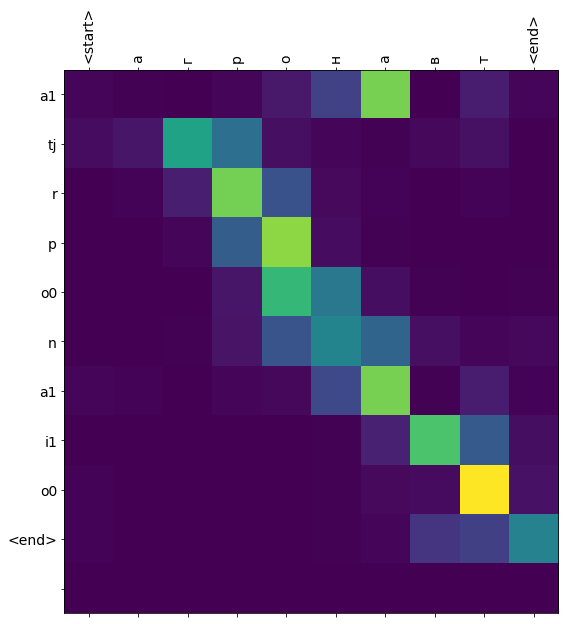

In [ ]:
translate(u'агронавт')

Input: <start> н а х о х л и в ш и с ь <end>
Predicted translation: a0 n a0 n z lj l dj zj e0 rj v <end> 


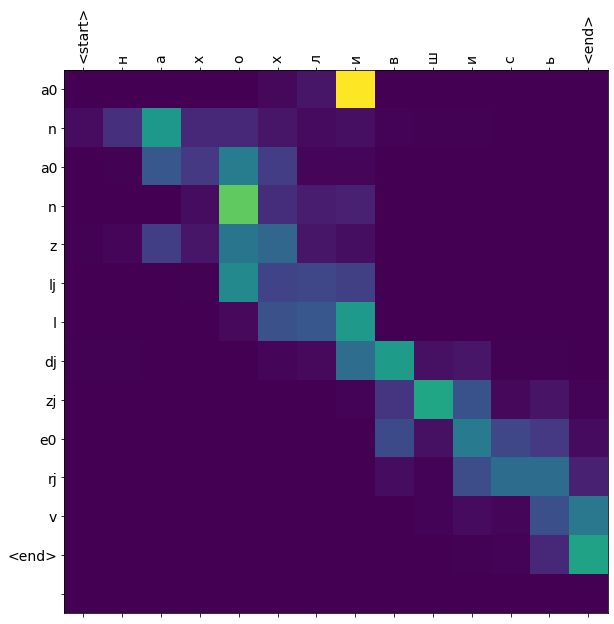

In [ ]:
translate(u'нахохлившись')

Input: <start> а а в в а а а <end>
Predicted translation: a1 a0 i1 i1 a1 a0 <end> 


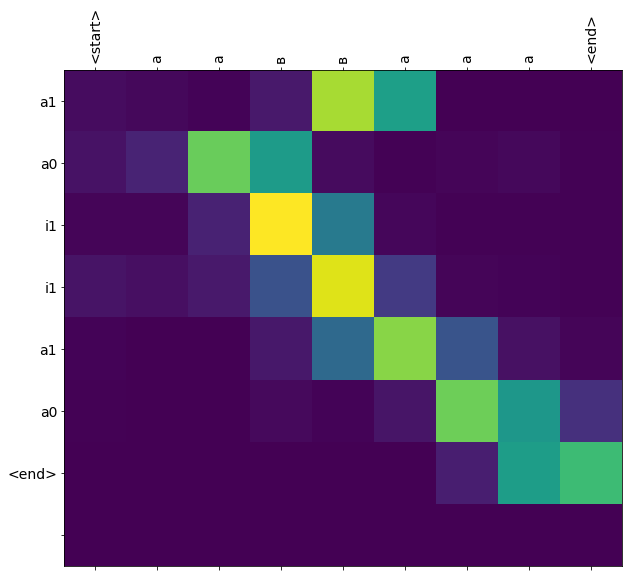

In [ ]:
translate(u'ааввааа')

#To conclude

Что сделано? Взят вариант seq2seq модели для перевода, адаптирован под фонетическое транскрибирование. Много мороки с предобработкой, долгое обучение: пришлось взять всегоа 10% от общего объема данных. На таком количестве семплов качество очень плохое, хотя и функция потерь показывает низкие значения.